In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import numpy as np

import matplotlib.pyplot as plt

import mean_variance as mv
import risk_parity as rp
import backtest as bt

# Purpose of the Notebook

# All ETF

Based on our defined Musk's TSLA exposure related risks, we will use the following assets to hedge his factor risks:

- Commodity
- Nominal Bond/ TIPS

In [66]:
# data
idx = pd.date_range('2016/1/1','2021/3/1')

data_etf = pd.read_csv('./data/ETF_data.csv', index_col=0, sep=';',decimal='.')
data_etf = data_etf.astype('float')
data_etf.index = pd.to_datetime(data_etf.index, format = '%d/%m/%Y')
data_etf = data_etf.sort_index()
data_etf = data_etf.pct_change().apply(lambda x: np.log(1+x))
data_etf = data_etf.iloc[2:,:]
data_etf = data_etf.loc[data_etf.index.isin(idx)]

commodity = data_etf['INVESCO OPTIMUM YIELD DIVERS']
corp_bond = data_etf['ISHARES IBOXX INVESTMENT GRA']
nom_bond = data_etf['ISHARES 1-3 YEAR TREASURY BO']
vix = data_etf['PRO VIX MT FUT']
sp500 = data_etf['SPDR S&P 500 ETF TRUST']
value = data_etf['ISHARES RUSSELL 2000 VALUE E']
mom = data_etf['ISHARES MSCI USA MOMENTUM FA']

# sp500


# Equal Weighted

In [3]:
### Equal weight

def equal_weight(Assets = [commodity, corp_bond, nom_bond, vix]):
    asset_weights = [1/len(Assets)]*len(Assets)
    weights = []
    rtn_mat_list = []
    for i,asset in enumerate(Assets):
        weights.extend([asset_weights[i]/len(asset)] * len(asset))
        rtn_mat_list.append(pd.concat([rtn for rtn in asset],axis=1).dropna())
    weights = np.matrix(weights)
    rtn_mat = pd.concat(rtn_mat_list,axis=1).dropna()
    rtn_mat = rtn_mat.replace(float('inf'),0)
    rtn_mat = rtn_mat.replace(-float('inf'),0)
    period_rtn = rtn_mat @ weights.T
    
    return period_rtn

In [4]:
# monthly_ew = equal_weight()

In [67]:
bt.Parameters.set_param(risk_aversion = 3.0, 
                        risk_premium = 0.10, 
                        trading_days_pa = 252, 
                        rebalance_freq_days = 21,
                        data_time_step_days = 1)

In [68]:
rtn_mat = pd.concat([commodity,corp_bond,nom_bond,vix,sp500,mom,value],axis=1).dropna()
rtn_mat.columns = ['commo', 'corp_bond','nom_bond','VIX','SP500','mom','value']

In [69]:
ew_weights = pd.DataFrame(np.ones((len(rtn_mat),7))*1/7,index = rtn_mat.index)
ew_weights.columns =['commo', 'corp_bond','nom_bond','VIX','SP500','mom','value']

In [70]:
rtn_mat

,commo,corp_bond,nom_bond,VIX,SP500,mom,value
Date,,,,,,,
2016-01-05,-0.009109,0.000526,-0.000592,-0.013994,0.001694,0.004724,0.004539
2016-01-06,-0.018470,0.003939,0.000592,0.016055,-0.012694,-0.005281,-0.011777
2016-01-07,-0.004671,0.000786,0.000355,0.050520,-0.024284,-0.022546,-0.026958
2016-01-08,-0.002009,0.000785,0.000710,0.040238,-0.011022,-0.009594,-0.016321
2016-01-11,-0.025799,-0.003233,0.000355,-0.011585,0.000974,0.006025,-0.000350
...,...,...,...,...,...,...,...
2021-02-23,0.004548,0.000755,0.000116,-0.017315,0.001214,-0.008709,-0.003252
2021-02-24,0.014081,0.001509,-0.000290,-0.026976,0.010959,0.006866,0.026932
2021-02-25,-0.007861,-0.015959,-0.001449,0.033036,-0.024391,-0.039256,-0.032682


In [71]:
ew_simulator = bt.Simulator("Equal Weighted", initial_book_size=1)
ew_weights_lag = ew_simulator.add_weights_lag(ew_weights, lag=0)
# tc_coeff=np.array([0.002,0.0015,0.,0.005])
# hc_coeff = np.array([0.0075, 0.005, 0., 0.001])
tc_coeff=np.array([0.0015,0.0015,0.0015, 0.005, 0.005, 0.005, 0.005])
hc_coeff = np.array([0.005,0.005,0.005, 0.001, 0.001, 0.001, 0.001])
ew_V_t_m, ew_log_ret_m, ew_turnover_df_m = ew_simulator.cal_pnl(ew_weights_lag, 
                                                          rtn_mat, 
                                                          tcost_coeff=tc_coeff,
                                                          hodling_cost_coeff=hc_coeff)

In [73]:
long_bond = pd.read_csv('data/DGS20.csv',index_col=0)
long_bond.loc[long_bond['DGS20']=='.'] = 0
long_bond = pd.to_numeric(long_bond['DGS20'], errors = 'ignore').dropna()
# since FRED expressed returns in annual % form, we convert back to decimal monthly return
long_bond = (1+long_bond).apply(np.log)/360/100
long_bond.index = pd.to_datetime(long_bond.index)
long_bond = long_bond.replace(float('inf'),0)
long_bond = long_bond.replace(-float('inf'),0)
long_bond = long_bond.loc[long_bond.index.isin(idx)]

rtn_mat['rf_ret'] = long_bond

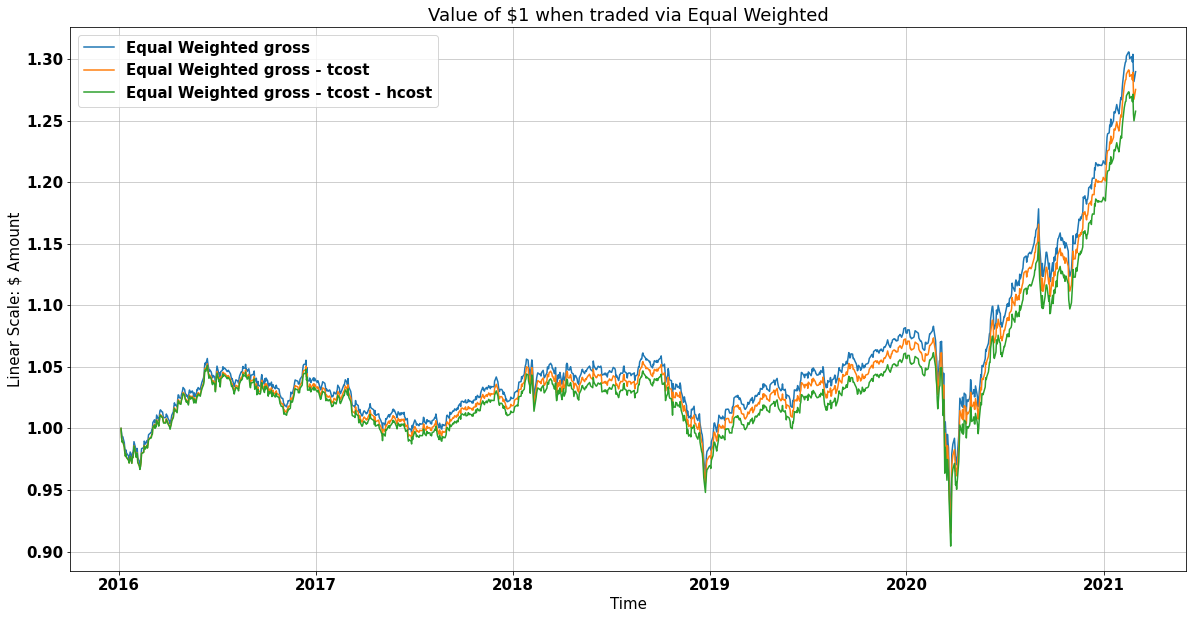

In [72]:
visualizer = bt.Visualizer()
visualizer.plot_pnl(pnl_data=ew_V_t_m, 
                    strategy_name="Equal Weighted", 
                    initial_book_size=1, 
                    scale= 'linear')

In [74]:
indicator = bt.Indicator()
ew_stats = indicator.agg_stats(ew_log_ret_m, 
                               rtn_mat, 
                               ew_V_t_m,
                               ew_turnover_df_m)
visualizer.show_stats(ew_stats)

                                                            Mean Annualized Performance Statistics
+--------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------+
|                                      |   Sharpe Ratio |   Returns (%) |   Volatility (%) |   Turnover (%) |   Skewness |   Kurtosis |   Max Drawdown (%) |
|--------------------------------------+----------------+---------------+------------------+----------------+------------+------------+--------------------|
| Equal Weighted gross                 |           0.59 |          4.95 |             7.11 |          56.46 |      -0.06 |       0.09 |             -14.73 |
| Equal Weighted gross - tcost         |           0.56 |          4.73 |             7.12 |          56.46 |      -0.06 |       0.09 |             -14.78 |
| Equal Weighted gross - tcost - hcost |           0.52 |          4.46 |             7.12 |          56.48 |      -

# Minimum Variance

In [25]:
mv.min_var_multi(rtn_mat)

100%|██████████| 1245/1245 [00:01<00:00, 841.20it/s]


,Commodity,Corp Bonds,Nominal Bonds,VIX,SP500
Date,,,,,
2016-03-21,-0.004014,-0.080087,1.053577,0.002460,0.028064
2016-03-22,-0.002605,-0.083862,1.055273,0.003111,0.028083
2016-03-23,-0.002318,-0.085178,1.057148,0.002850,0.027499
2016-03-24,-0.003112,-0.084883,1.058063,0.002238,0.027694
2016-03-28,-0.002851,-0.085029,1.055136,0.003567,0.029177
...,...,...,...,...,...
2021-02-23,0.002039,-0.019189,1.010442,0.000047,0.006661
2021-02-24,0.002310,-0.017755,1.009762,-0.000450,0.006133
2021-02-25,0.001017,-0.039795,1.039427,-0.001295,0.000647


# Risk Parity

In [26]:
rp_model = rp.RiskParity(1,list(rtn_mat.columns),rtn_mat,12,10,12)

In [27]:
trade, trade_pct, weight, returns = rp_model.get_flow()

In [28]:
weight.columns

Index(['target_Commodity', 'target_Corp Bonds', 'target_Nominal Bonds',
       'target_VIX', 'target_SP500', 'real_Commodity', 'real_Corp Bonds',
       'real_Nominal Bonds', 'real_VIX', 'real_SP500'],
      dtype='object')

Target and real weights


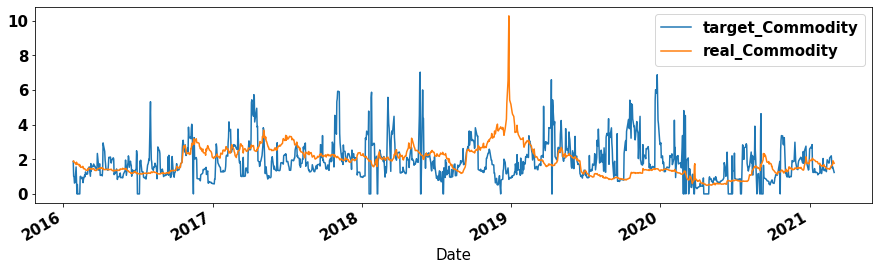

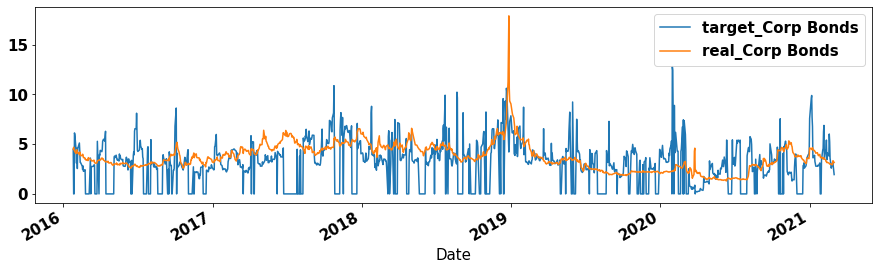

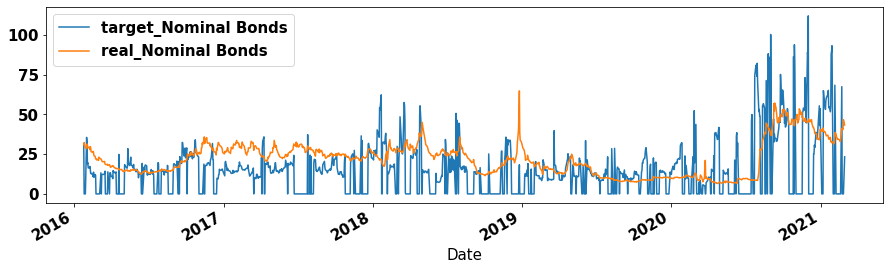

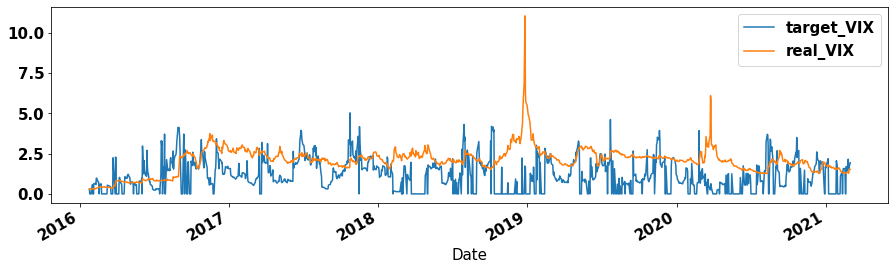

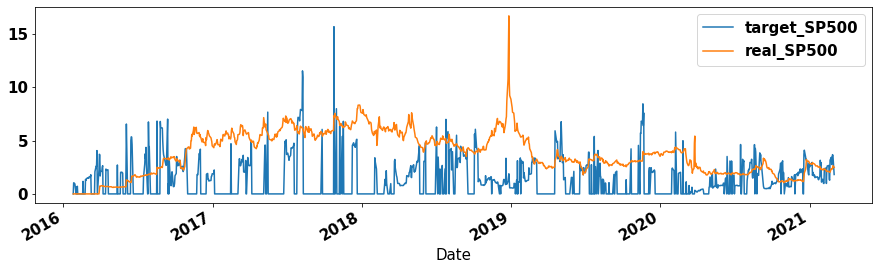

In [29]:
print("Target and real weights")
weight[['target_Commodity','real_Commodity']].plot(figsize = (15,4))
plt.show()

weight[['target_Corp Bonds','real_Corp Bonds']].plot(figsize = (15,4))
plt.show()

weight[['target_Nominal Bonds','real_Nominal Bonds']].plot(figsize = (15,4))
plt.show()

weight[['target_VIX','real_VIX']].plot(figsize = (15,4))
plt.show()

weight[['target_SP500','real_SP500']].plot(figsize = (15,4))
plt.show()